**Demo notebook to go through my Options Hedging Project**

Starting off with imports from standard libaries and my custom helper functions

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
from options_lib.data import data_load
from options_lib.plots import plot_spy_and_options, plot_hedging_errors, plot_positions, plot_delta_positions, plot_portfolio_and_pnl, plot_hedging_simulation_stats, plot_hedging_summary_distributions, plot_performance_by_interval_length, plot_underlying_for_simulation, plot_delta_vega_hedging, plot_delta_vega_gamma_hedging
from options_lib.bs import black_scholes_call, black_scholes_delta, black_scholes_vega, implied_volatility, black_scholes_gamma
from options_lib.hedging import simple_delta_hedging, delta_hedging, run_hedging_intervals, delta_vega_hedging, delta_vega_gamma_hedging

Here I load the feather data into a dataframe. The data contains 168 data points: Data starts on 2022-04-20 and ends on 2022-12-16.

In [3]:
df = data_load("simulation_data/spy_221216_C380_C405.feather")

In [4]:
# Uncomment to see what the dataframe looks like
#df.head()

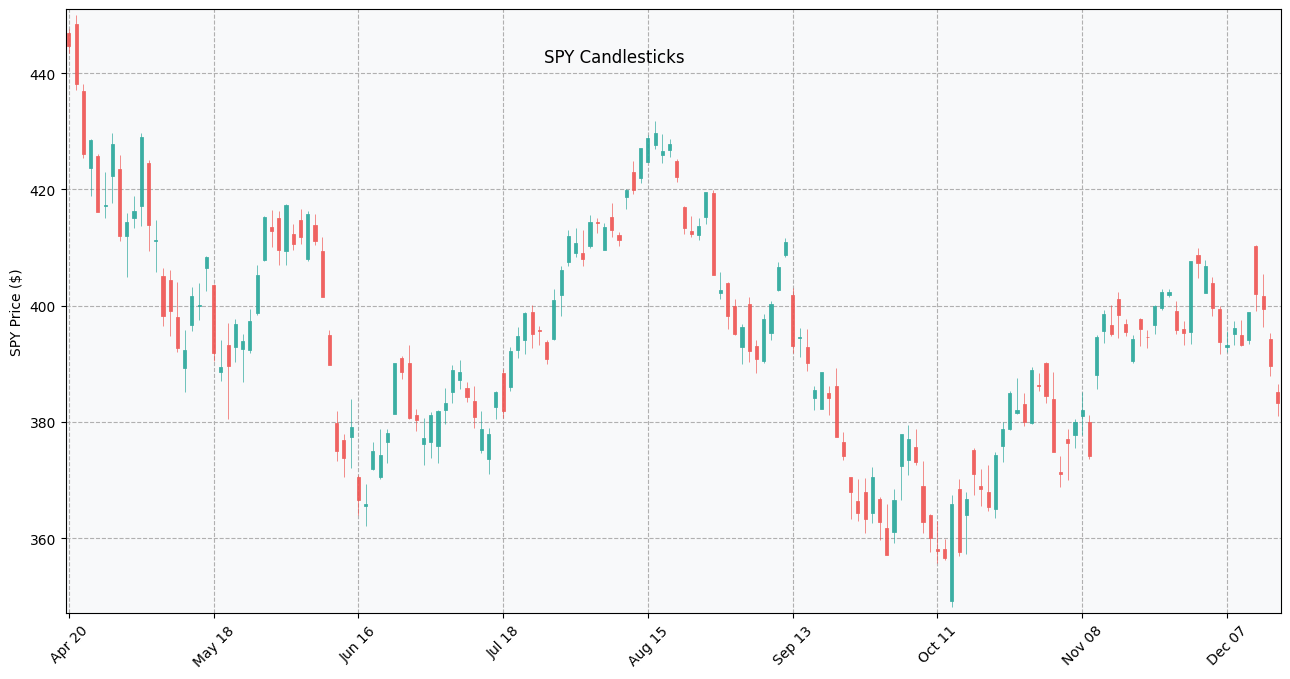

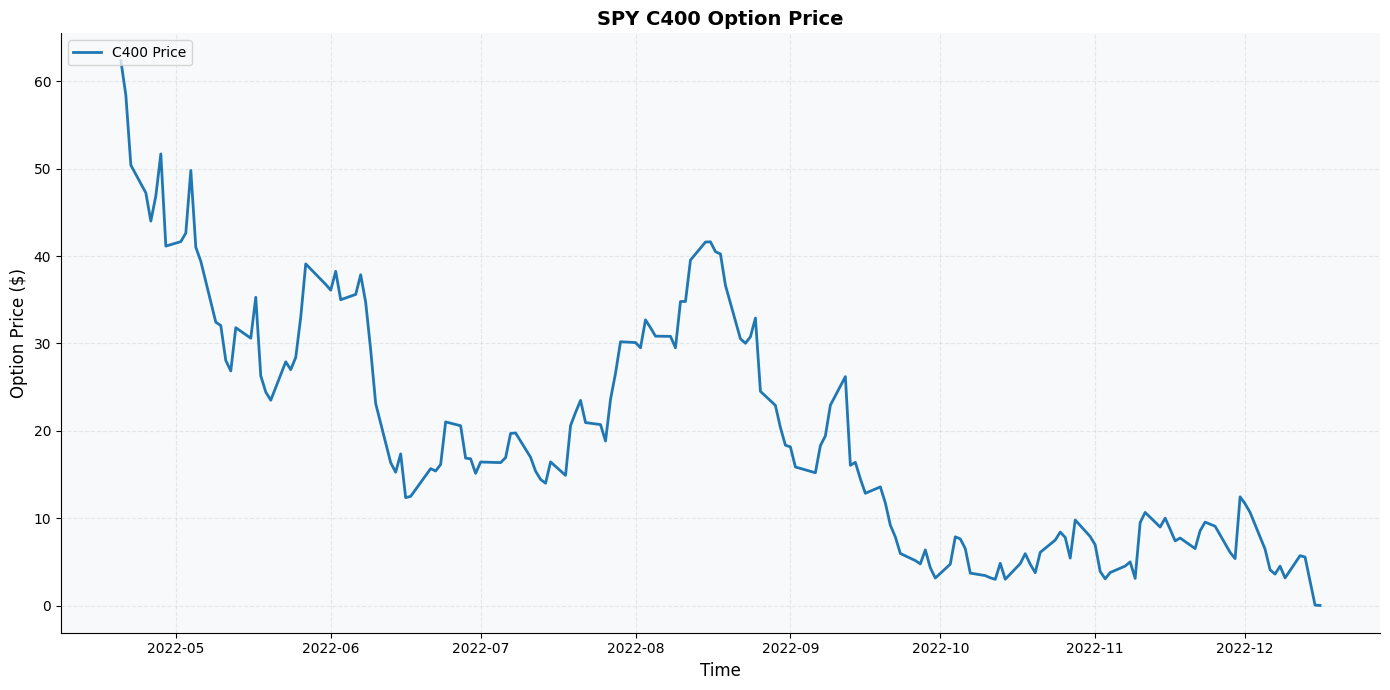

Data starts: 2022-04-20 00:00:00
Data ends: 2022-12-16 00:00:00
Number of days: 240
Number of data points: 168


In [5]:
# Uncommet to see the data plotted
plot_spy_and_options(df, ["C400"])

Here I run a very simple delta-hedging simulation taking the last 45 days as the hedging period for a SPY Call C400 with maturity of 16/12/2022. At this point there is no transaction costs or additional constraints considered. 

In [6]:
maturity = pd.to_datetime('2022-12-16')

start_date = maturity - pd.Timedelta(days=45)
end_date = maturity - pd.Timedelta(days=0)

df_hedge, deltas, OP, RE, iv_values, A_errors = simple_delta_hedging(
    df, start_date, end_date, "C400", K=400, r=0.05, maturity=maturity, freq=1
    )

Mean Squared Hedging Error: 0.6786


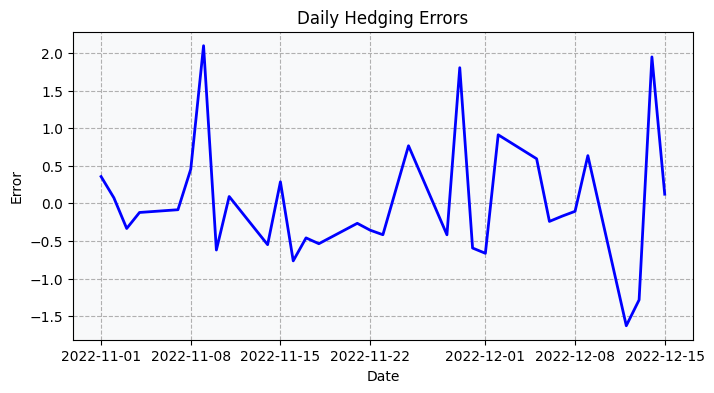

In [7]:
plot_hedging_errors(df_hedge, A_errors)

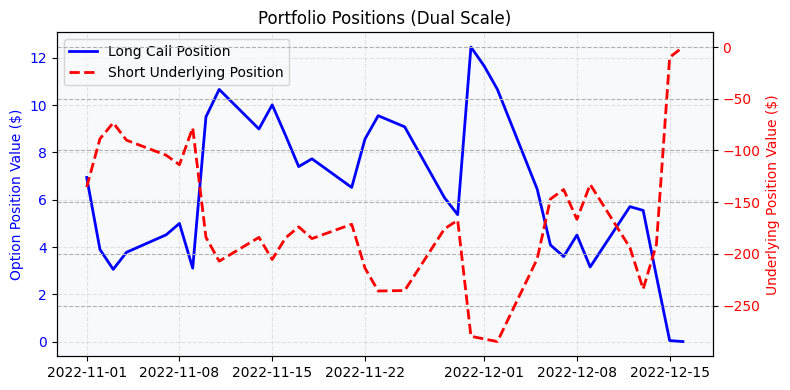

In [8]:
plot_positions(df_hedge, OP, RE, deltas)

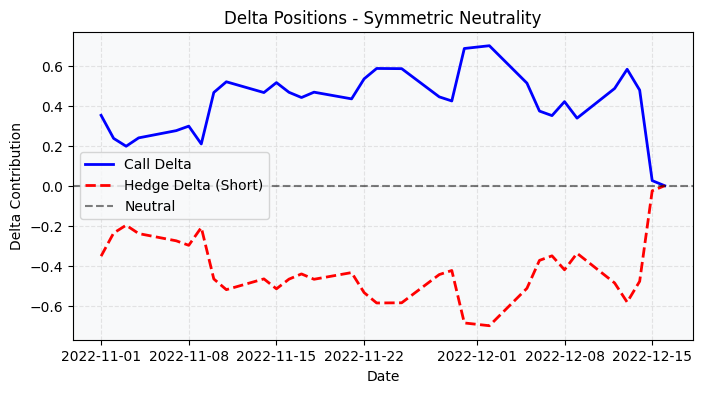

In [9]:
plot_delta_positions(df_hedge, deltas)

**Delta Hedging with transaction costs**

Now for a more realistic simulation with transaction costs, PnL calculations, and portfolio simulation.

In [10]:
maturity = pd.to_datetime('2022-12-16')
start_date = maturity - pd.Timedelta(days=45)
end_date = maturity - pd.Timedelta(days=0)

df_hedge, deltas, OP, RE, iv_values, A_errors, shares_held, cash_position, portfolio_values, cumulative_costs, pnl = delta_hedging(
    df, start_date=start_date, end_date=end_date, option_col="C400", K=400, r=0.05, 
    maturity=maturity, freq=1, transaction_cost_per_share=0.01, transaction_cost_percentage=0.0005
)

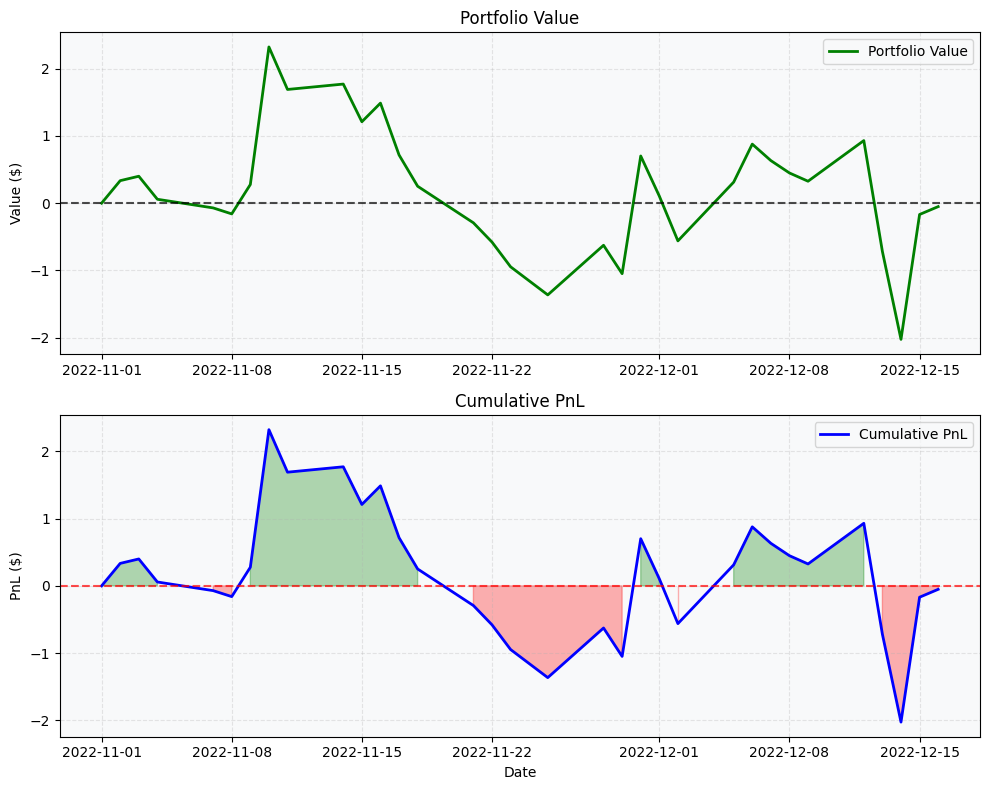

In [11]:
plot_portfolio_and_pnl(df_hedge.index, portfolio_values, pnl)

**Full analysis using 5 different data sets, ultimatly 157 simulations and then calculating averages and such.**

In [12]:
# Main analysis
data_folder = "simulation_data"
files = [f for f in os.listdir(data_folder) if f.endswith('.feather')]
all_stats = []

for file in files:
    df = data_load(os.path.join(data_folder, file))
    maturity = df.index[-1]
    
    call_cols = [col for col in df.columns if col.startswith('C')]
    
    for option_col in call_cols:
        try:
            K = int(option_col[1:])
        except ValueError:
            continue
                    
        stats_df = None
        lengths_tried = []
        
        for interval_length in [45, 30, 20]:
            step_size = max(5, interval_length // 4)
            lengths_tried.append(f"{interval_length}d(step{step_size})")
            
            temp_stats = run_hedging_intervals(
                df, maturity, 
                interval_length=interval_length, 
                step_size=step_size, 
                num_intervals=10,
                option_col=option_col, 
                K=K
            )
            
            if len(temp_stats) > 0:
                stats_df = temp_stats
                break
        
        if stats_df is not None:
            stats_df['dataset'] = file
            stats_df['option'] = option_col
            stats_df['strike'] = K
            stats_df['interval_length'] = interval_length
            all_stats.append(stats_df)

if all_stats:
    combined_stats = pd.concat(all_stats, ignore_index=True)
    print(len(combined_stats), "hedging simulations completed across all datasets and options.")
    length_summary = combined_stats.groupby('interval_length').size()

else:
    print("No results collected")


157 hedging simulations completed across all datasets and options.


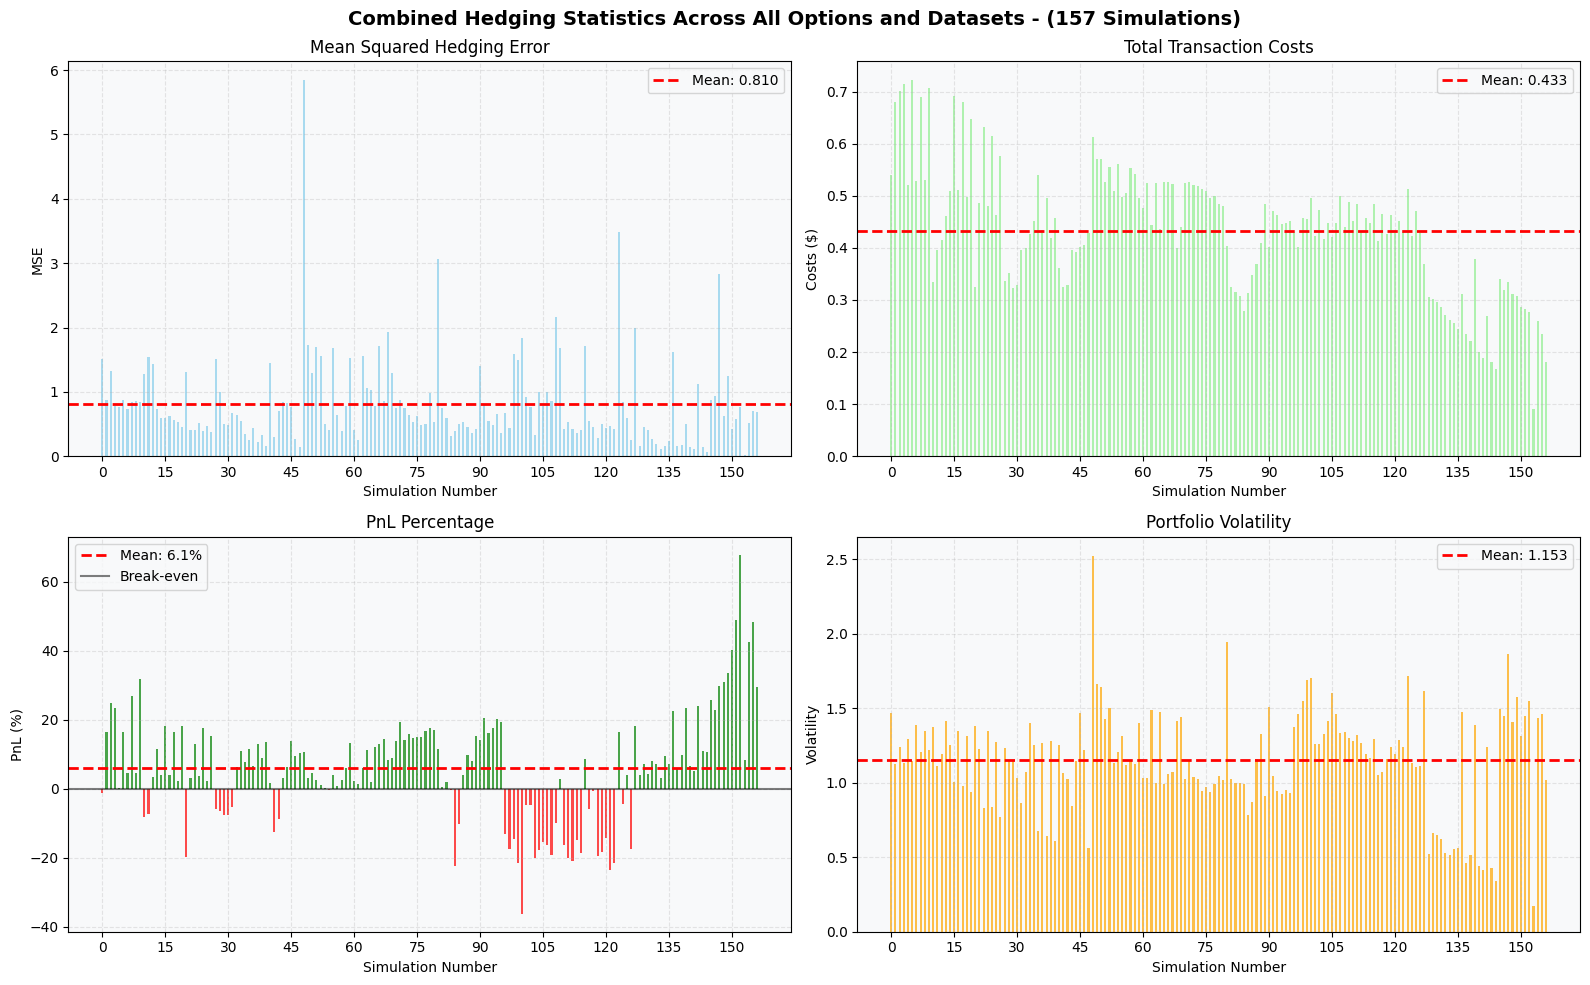

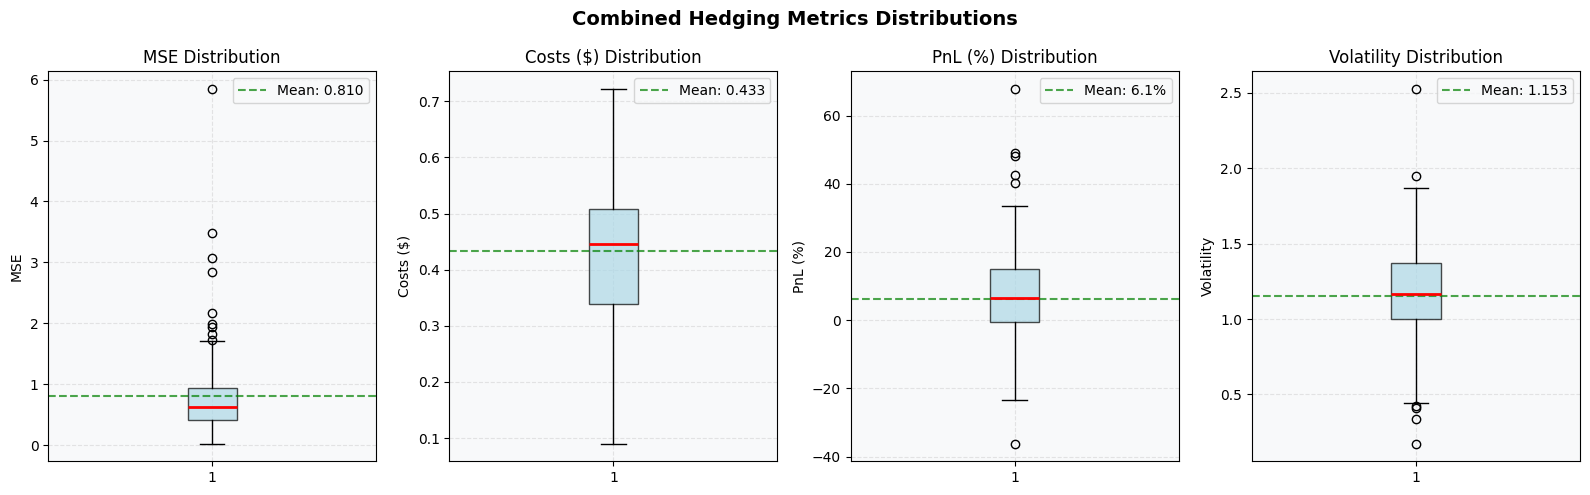

In [13]:
plot_hedging_simulation_stats(combined_stats, title="Combined Hedging Statistics Across All Options and Datasets - (157 Simulations)")
plot_hedging_summary_distributions(combined_stats, title="Combined Hedging Metrics Distributions")

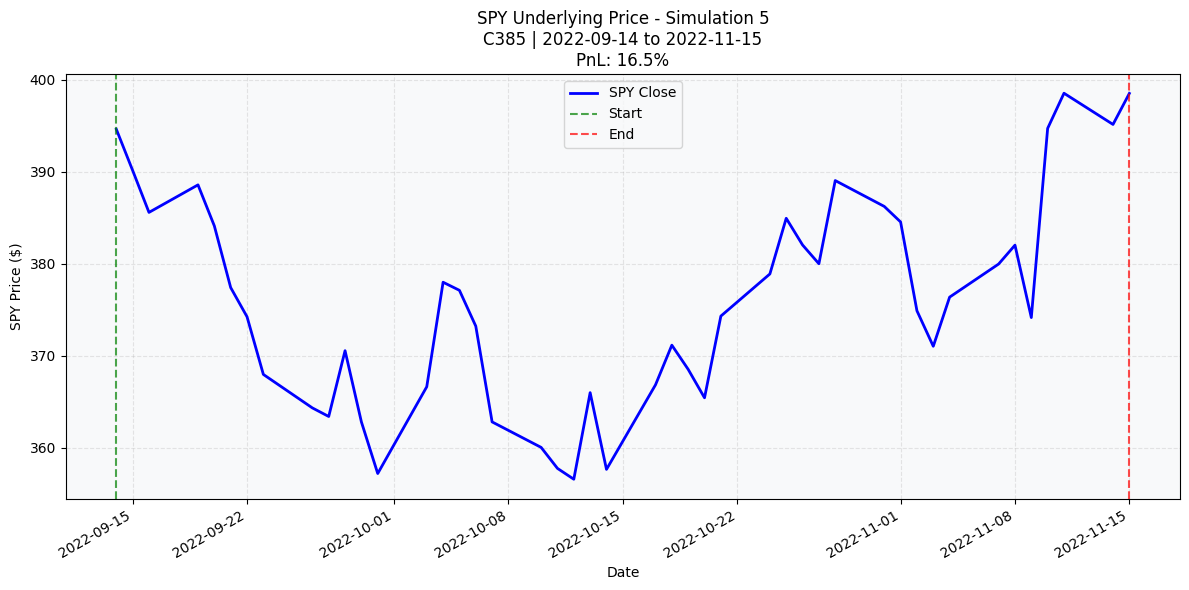

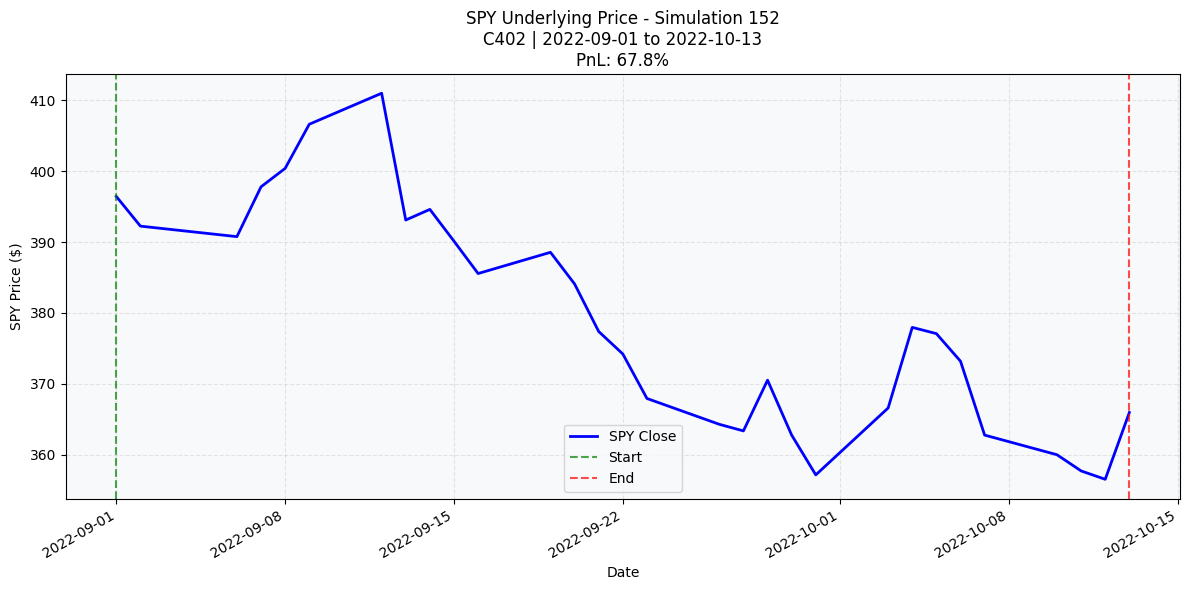

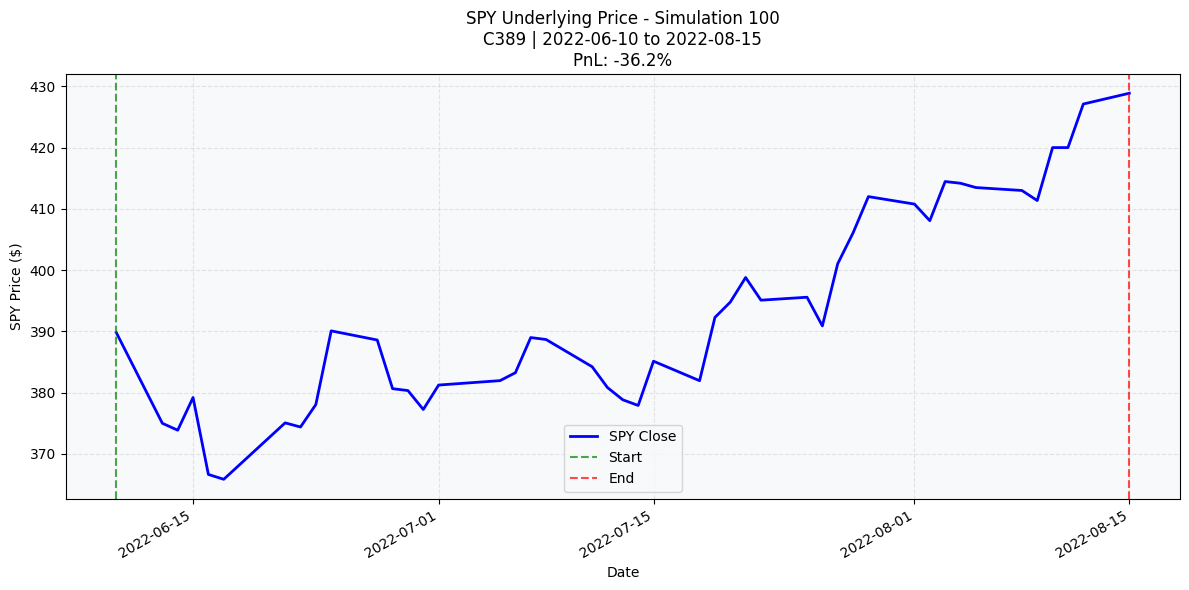

In [14]:
data_dict = {}
for file in files:
    df = data_load(os.path.join(data_folder, file))
    data_dict[file] = df

# Plot underlying for simulation 5
plot_underlying_for_simulation(combined_stats, 5, data_dict)

# Plot for the best performing simulation
best_idx = combined_stats['pnl_percentage'].idxmax()
plot_underlying_for_simulation(combined_stats, best_idx, data_dict)

# Plot for the worst performing simulation  
worst_idx = combined_stats['pnl_percentage'].idxmin()
plot_underlying_for_simulation(combined_stats, worst_idx, data_dict)


Now Delta-Vega Hedging,

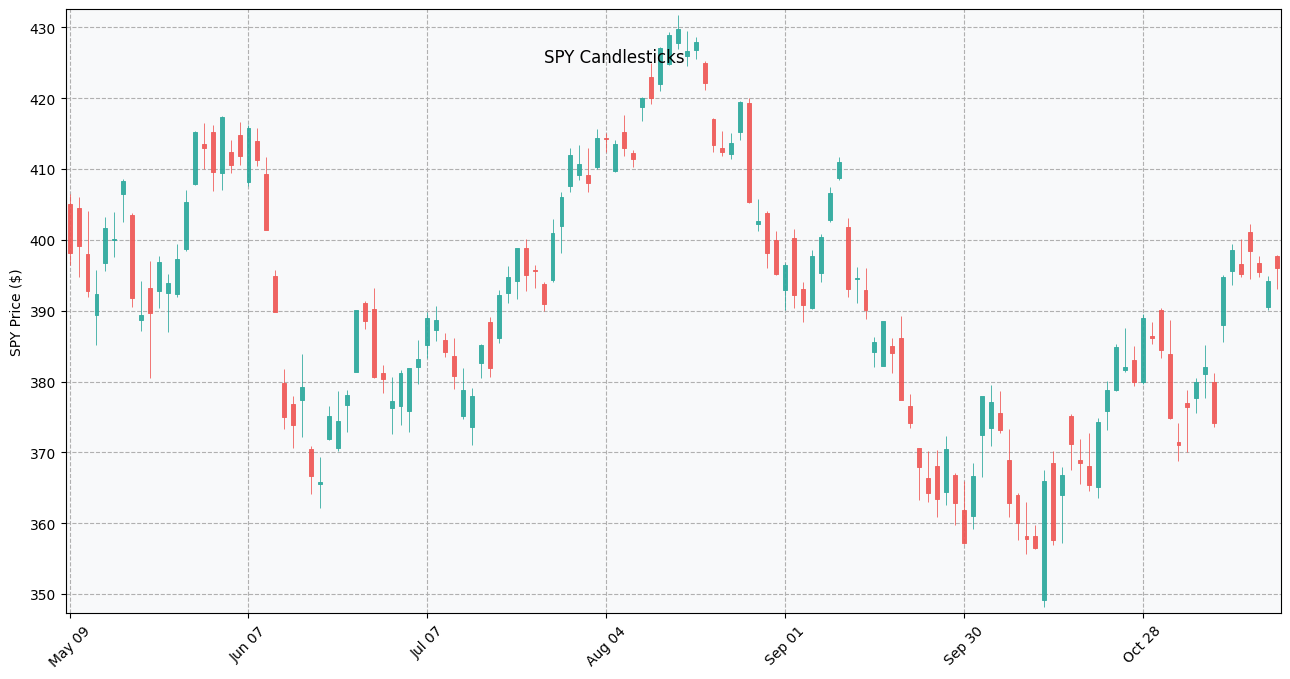

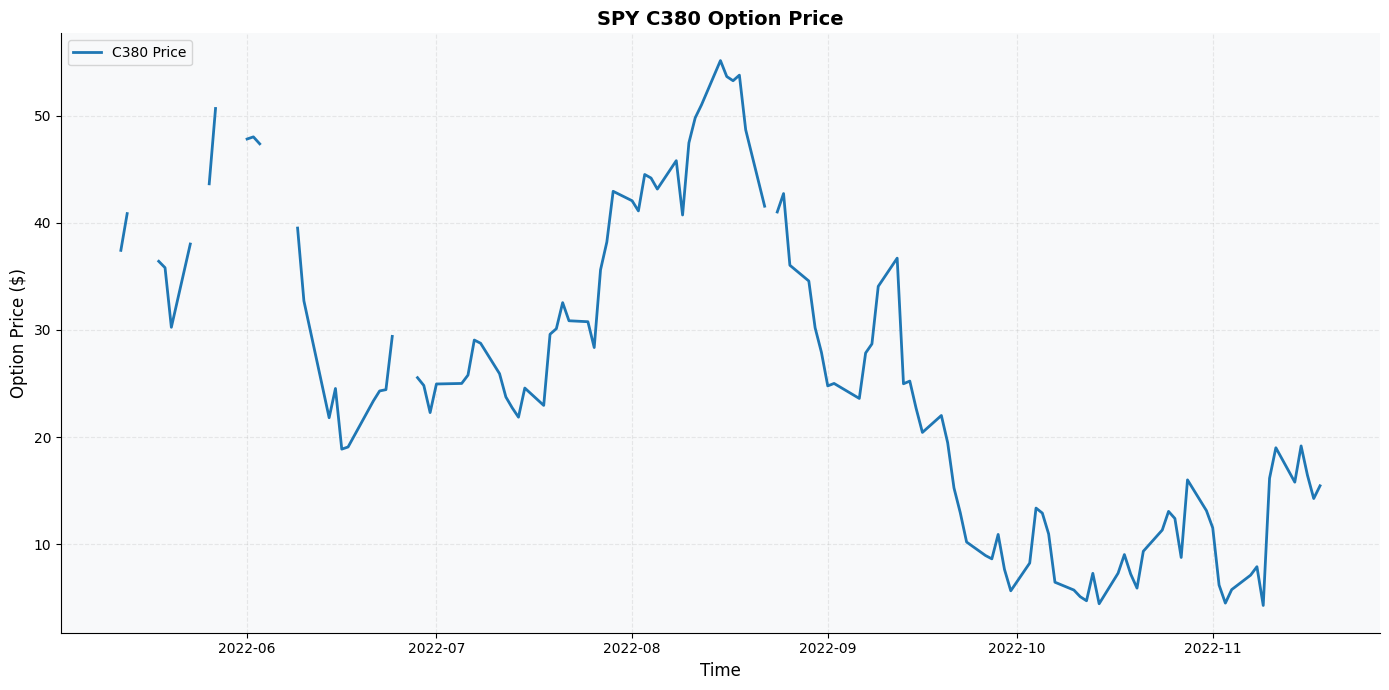

Data starts: 2022-05-09 00:00:00
Data ends: 2022-11-18 00:00:00
Number of days: 193
Number of data points: 136


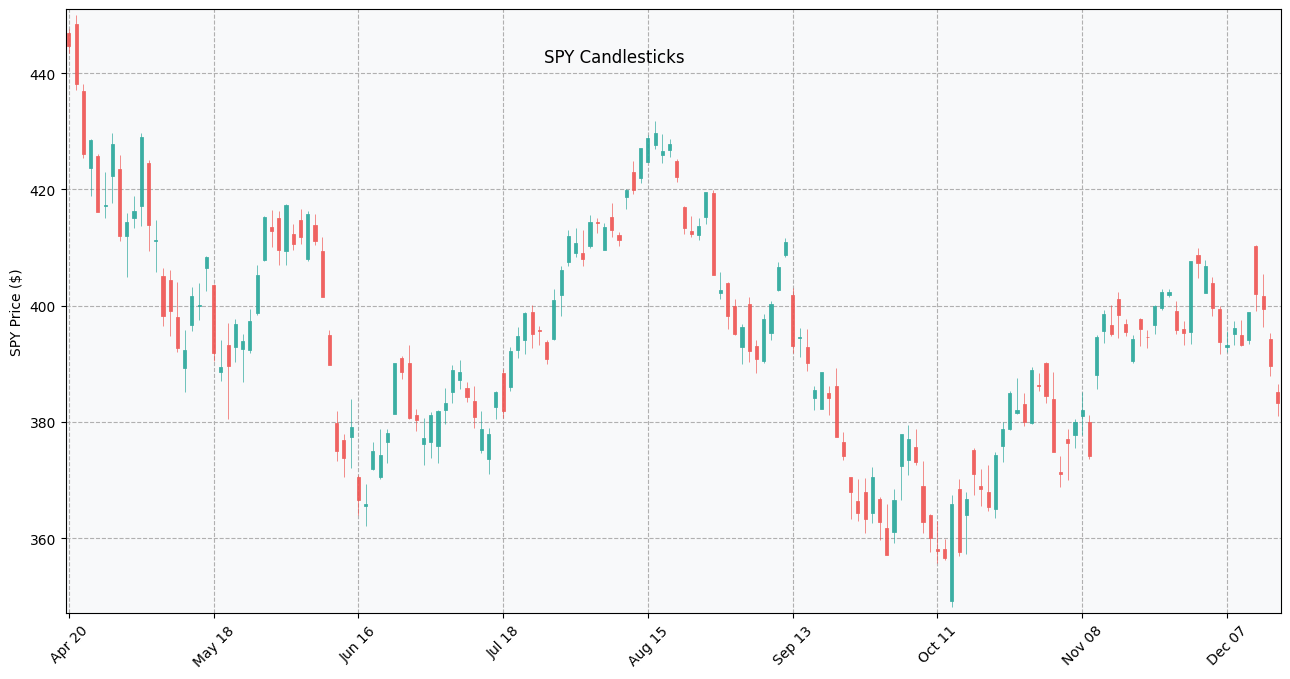

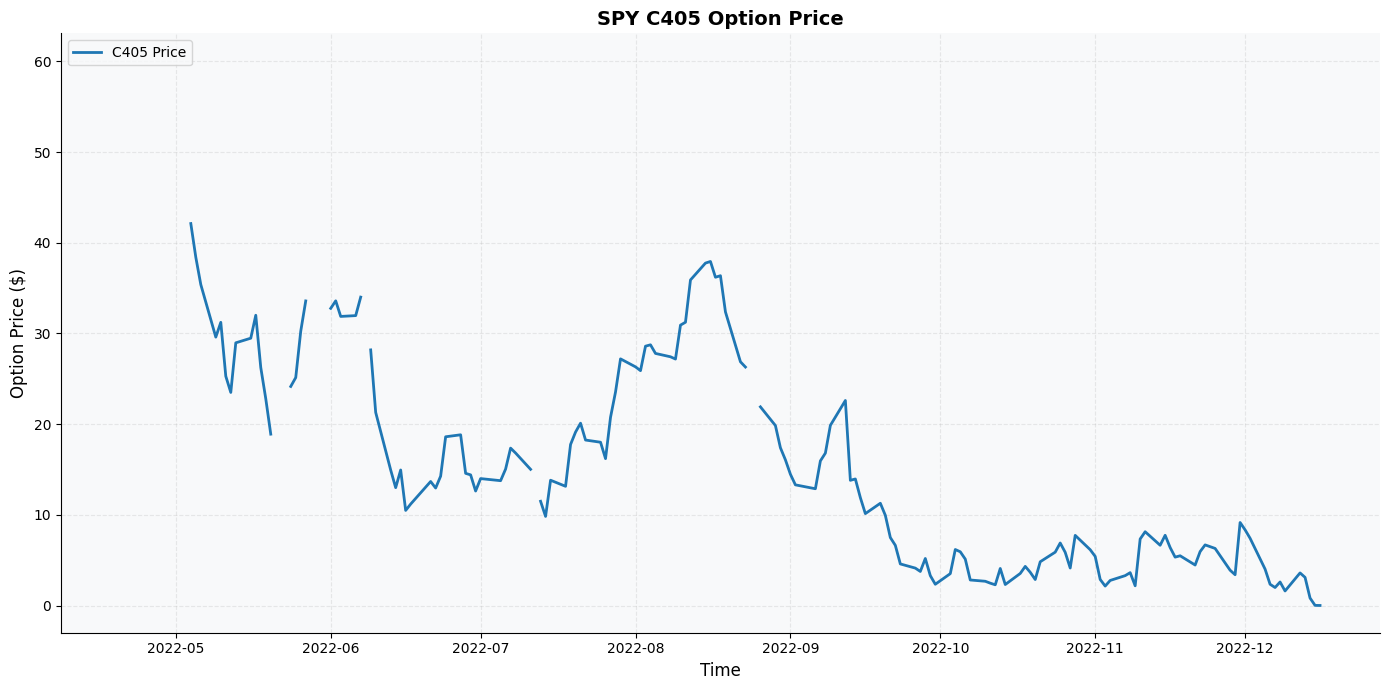

Data starts: 2022-04-20 00:00:00
Data ends: 2022-12-16 00:00:00
Number of days: 240
Number of data points: 168


In [15]:
# Load two datasets
df1 = data_load("simulation_data/spy_221118_C380_C405.feather")
df2 = data_load("simulation_data/spy_221216_C380_C405.feather")

plot_spy_and_options(df1, ["C380"])
plot_spy_and_options(df2, ["C405"])

In [16]:
start_date = pd.to_datetime('2022-10-01')
end_date = start_date + pd.Timedelta(days=45)

# Run delta-vega hedging
result = delta_vega_hedging(
    df1=df1, df2=df2,
    start_date=start_date, end_date=end_date,
    option_primary="C400", option_vega="C400",
    K_primary=400, K_vega=400,
    r=0.05, maturity1=df1.index[-1], maturity2=df2.index[-1],
    transaction_cost_per_share=0.01,
    transaction_cost_percentage=0.0005    
)


df_hedge, net_deltas, alphas, OP1, OP2, RE, iv1, iv2, A_errors, shares, vega_pos, cash, port_val, costs, pnl = result

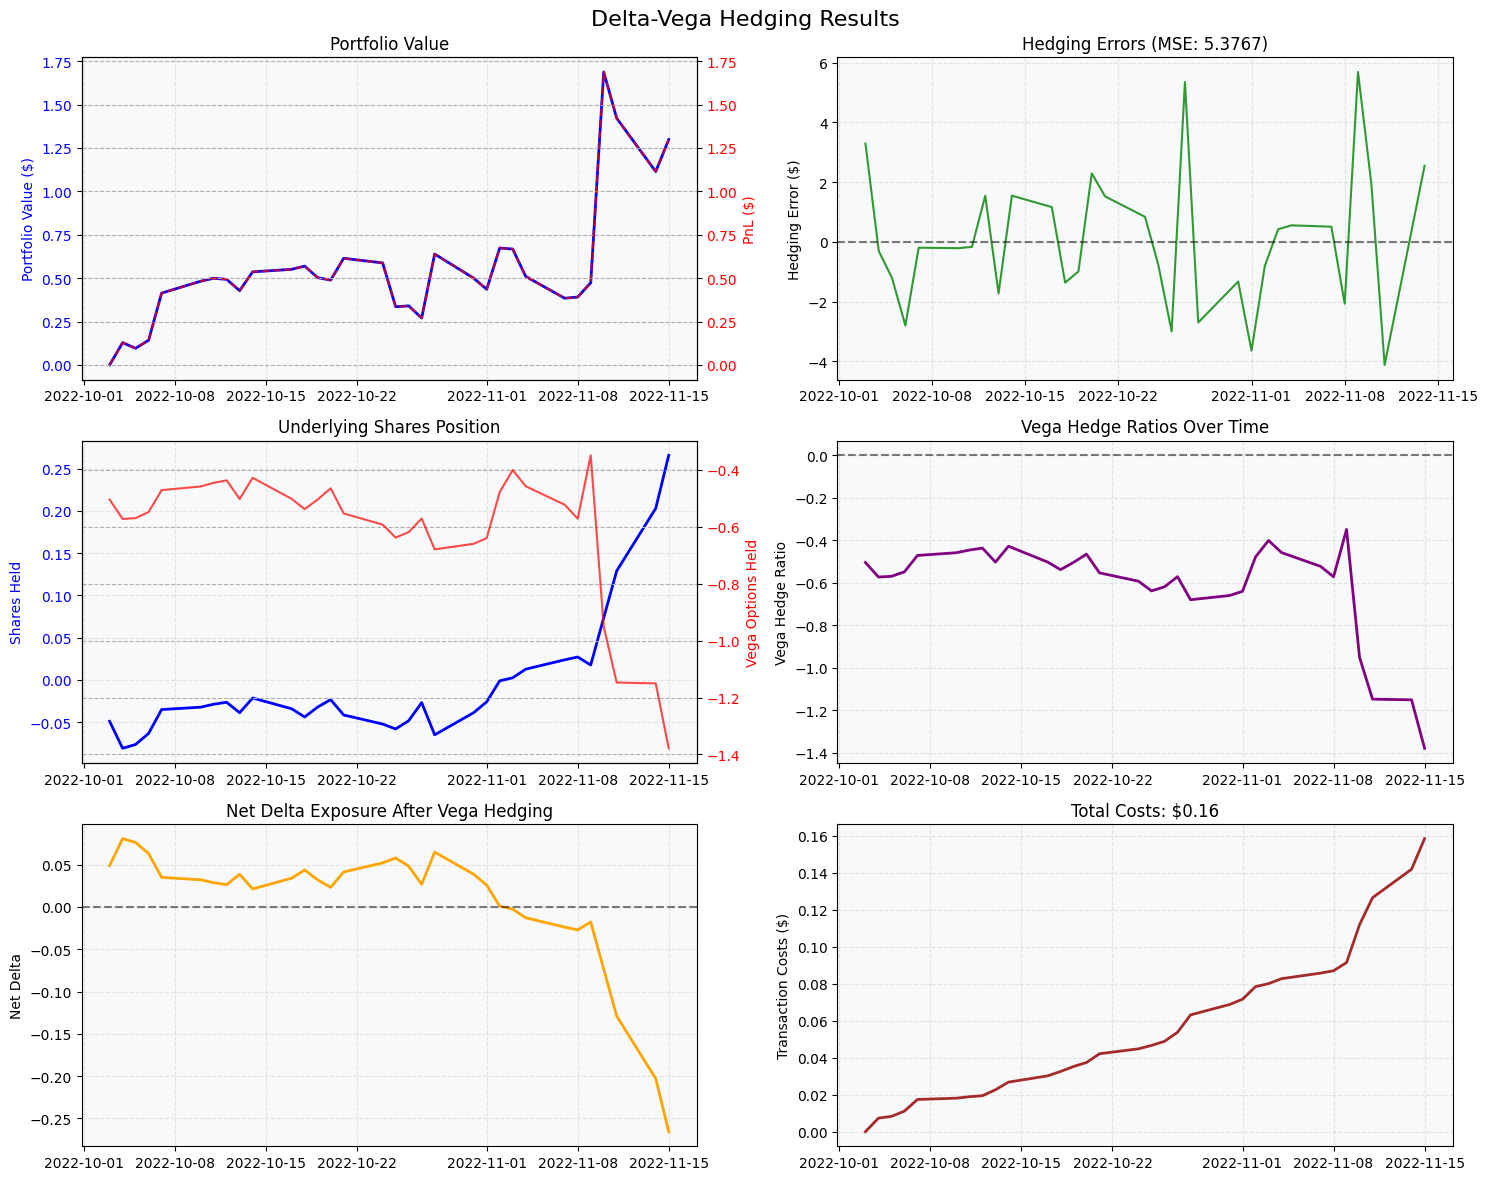

=== DELTA-VEGA HEDGING SUMMARY ===
MSE: 5.3767
RMSE: 2.3188
Mean Error: 0.0588
Final PnL: $1.30
Total Costs: $0.16
Average Vega Ratio: -0.6032
Final Net Delta: -0.2658


In [17]:
plot_delta_vega_hedging(df_hedge, net_deltas, alphas, OP1, OP2, RE, A_errors, shares, vega_pos, port_val, costs, pnl)

Successfully imported 'run_full_delta_vega_analysis'.
Found 5 files, creating 10 pairs for analysis.
Found pair: C380 (K=380, T=2022-08-19) and C380 (K=380, T=2022-11-18)
Skipping interval 0 due to missing data for pair C380-C380.
Skipping interval 1 due to missing data for pair C380-C380.
Skipping interval 2 due to missing data for pair C380-C380.
Skipping interval 3 due to missing data for pair C380-C380.
Skipping interval 4 due to missing data for pair C380-C380.
Skipping interval 5 due to missing data for pair C380-C380.
Found pair: C381 (K=381, T=2022-08-19) and C380 (K=380, T=2022-11-18)
Skipping interval 0 due to missing data for pair C381-C380.
Skipping interval 1 due to missing data for pair C381-C380.
Skipping interval 2 due to missing data for pair C381-C380.
Skipping interval 3 due to missing data for pair C381-C380.
Skipping interval 4 due to missing data for pair C381-C380.
Skipping interval 5 due to missing data for pair C381-C380.
Found pair: C382 (K=382, T=2022-08-19) 

,interval,start_date,end_date,data_points,calendar_days,mean_squared_error,total_costs,final_pnl,portfolio_volatility,max_portfolio_value,min_portfolio_value,pnl_percentage,strike_primary,strike_vega,maturity_diff_days
count,137.000000,137,137,137.0,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000
mean,2.131387,2022-06-15 01:24:05.255474432,2022-08-17 19:16:12.262773760,45.0,63.744526,17.138345,0.690837,0.317759,0.700627,1.603052,-1.766170,3.297806,398.875912,398.905109,78.941606
min,0.000000,2022-04-20 00:00:00,2022-06-23 00:00:00,45.0,63.000000,8.881680,0.196239,-2.756847,0.454788,0.000000,-4.458005,-60.805195,388.000000,390.000000,63.000000
25%,0.000000,2022-06-09 00:00:00,2022-08-12 00:00:00,45.0,63.000000,12.971578,0.339285,-0.406225,0.531659,0.774874,-2.123611,-3.953674,398.000000,400.000000,63.000000
50%,2.000000,2022-06-14 00:00:00,2022-08-17 00:00:00,45.0,64.000000,15.621734,0.620218,0.139246,0.613382,1.263535,-1.754814,1.033968,400.000000,400.000000,63.000000
75%,3.000000,2022-06-29 00:00:00,2022-08-31 00:00:00,45.0,64.000000,20.167951,0.924886,1.029365,0.712139,2.231792,-1.252641,6.824921,402.000000,400.000000,91.000000
max,9.000000,2022-07-14 00:00:00,2022-09-15 00:00:00,45.0,65.000000,33.560590,2.189896,5.849886,2.224276,6.051463,0.000000,122.127051,405.000000,405.000000,119.000000
std,2.235468,NaN,NaN,0.0,0.675508,5.318900,0.400095,1.388091,0.284121,1.178315,0.824983,20.533023,4.661238,4.839913,19.146404


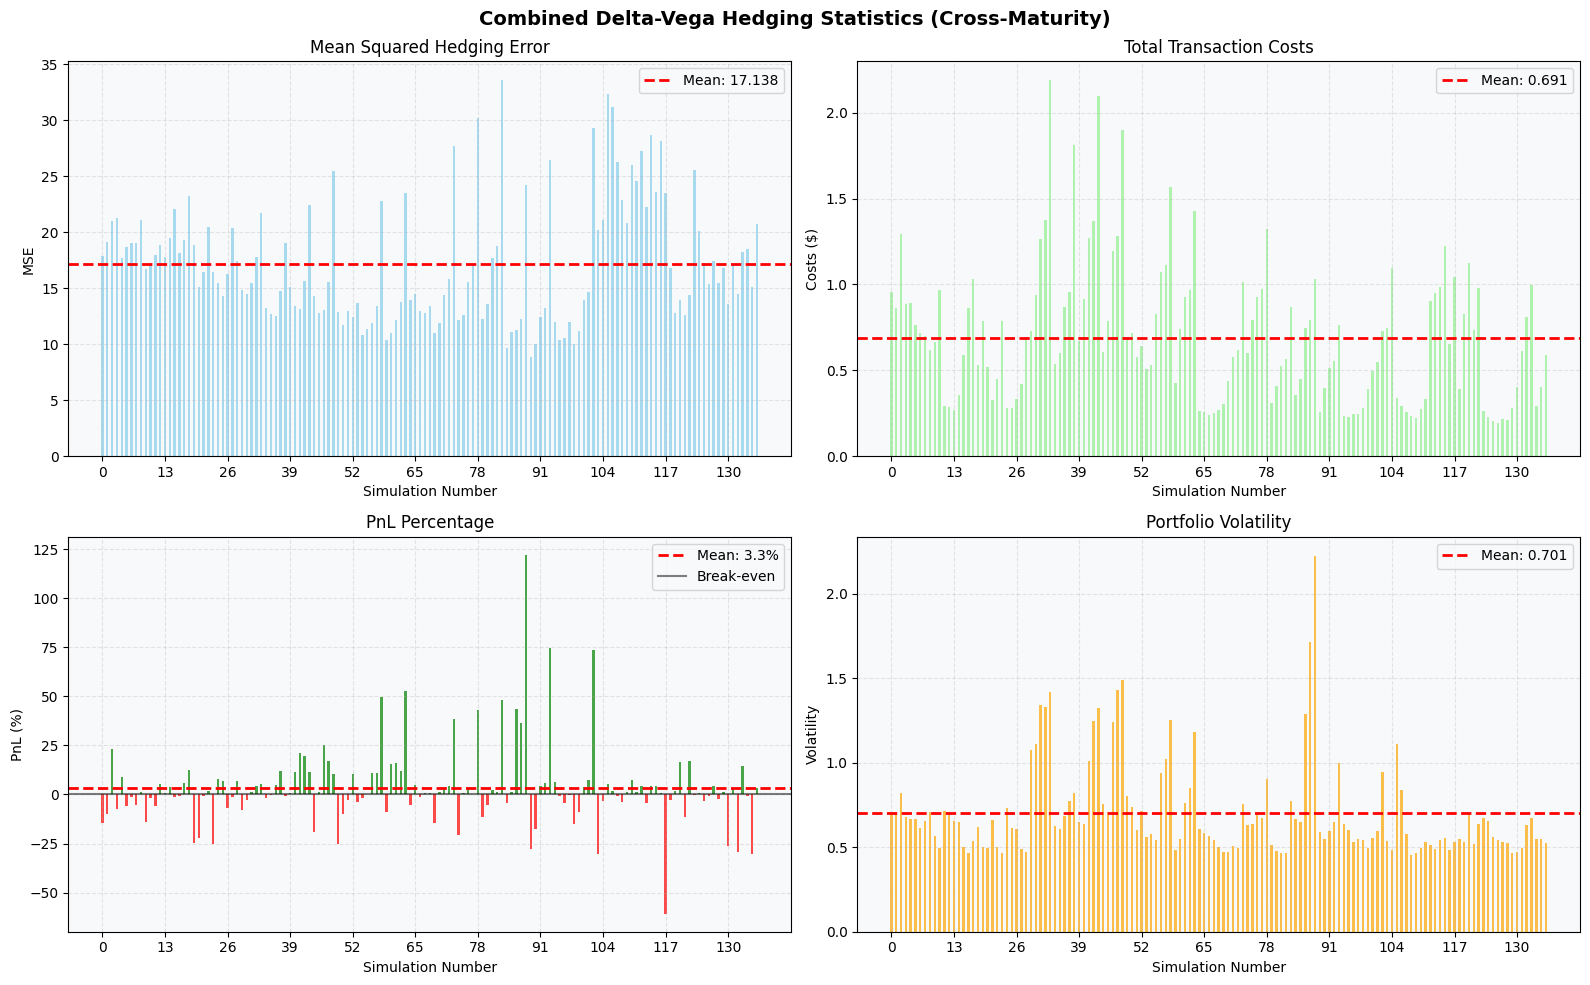

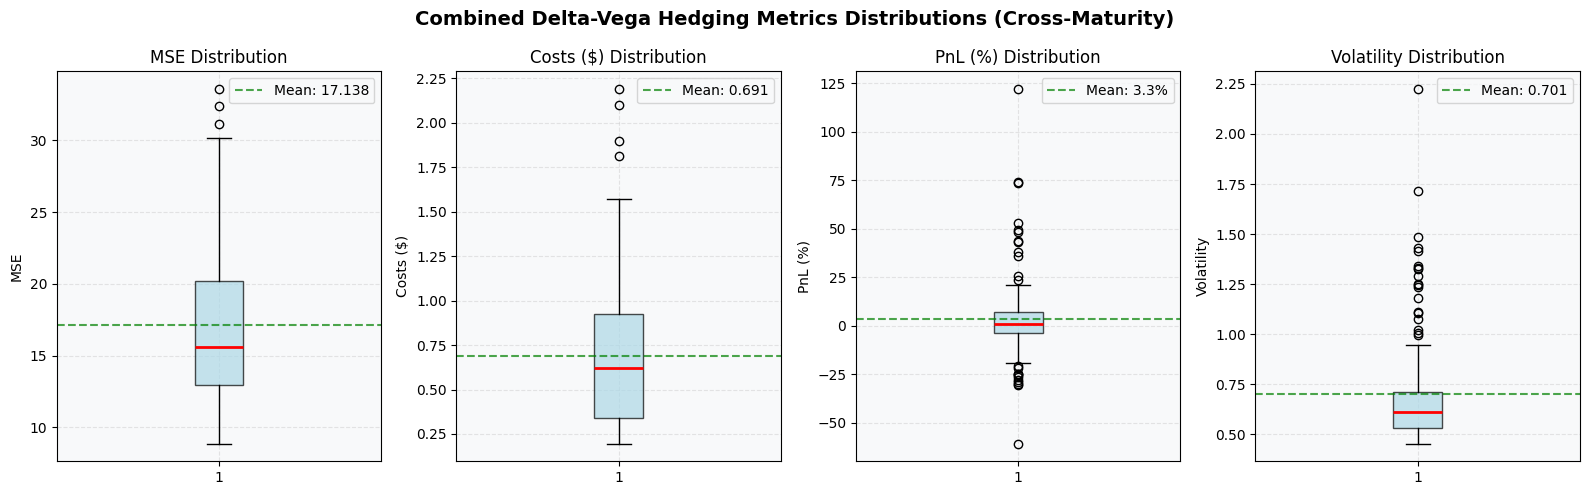

In [18]:
# Import necessary functions and libraries
import os
import pandas as pd
from IPython.display import display
from options_lib.plots import plot_hedging_simulation_stats, plot_hedging_summary_distributions

# Import the new delta-vega analysis function
try:
    from delta_vega_simulation import run_full_delta_vega_analysis
    print("Successfully imported 'run_full_delta_vega_analysis'.")
except ImportError:
    print("Could not import 'run_full_delta_vega_analysis'.")
    print("Please ensure 'delta_vega_simulation.py' is updated and in the same directory.")

# --- Main Delta-Vega Hedging Analysis (Cross-Maturity) ---

data_folder = "simulation_data"

# Run the full analysis.
# This function will handle finding file pairs, matching options, and running simulations.
# You can customize parameters like strike_tolerance, min_maturity_diff_days,
# interval_length, step_size, and num_intervals.
try:
    combined_stats = run_full_delta_vega_analysis(
        data_folder=data_folder,
        strike_tolerance=2,
        min_maturity_diff_days=30,
        interval_length=45,
        step_size=5,
        num_intervals=10
    )

    if combined_stats is not None and not combined_stats.empty:
        print(f"\n{len(combined_stats)} delta-vega hedging simulations completed.")
        
        print("\n--- Overall Delta-Vega Hedging Performance (Cross-Maturity) ---")
        display(combined_stats.describe())
        
        # Plot the aggregated results
        plot_hedging_simulation_stats(combined_stats, title="Combined Delta-Vega Hedging Statistics (Cross-Maturity)")
        plot_hedging_summary_distributions(combined_stats, title="Combined Delta-Vega Hedging Metrics Distributions (Cross-Maturity)")

    else:
        print("\nNo results were collected from the delta-vega simulations.")

except NameError:
    print("\n'run_full_delta_vega_analysis' is not defined. Please check the import.")
except Exception as e:
    print(f"\nAn error occurred during the analysis: {e}")